In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import scipy
import json
from matplotlib import cm as CM
#from model import CSRNet
#import torch
%matplotlib inline

from tqdm import tqdm
import PIL
import cv2
import random
import math
import sys
import pandas as pd

import numpy as np

from __future__ import print_function

from itertools import chain
import zipfile

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from torchsummary import summary

In [2]:
train = pd.read_csv('train.csv')
train['filename'] = train['filename'].replace({'\.\./': 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/'}, regex=True)#to have the right paths
cop=train.copy()

val = pd.read_csv('val.csv')
val['filename'] = val['filename'].replace({'\.\./': 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/'}, regex=True)#to have the right paths
print(train)
#train = train[:len(train)//10]
#val = val[:len(val)//10]

        Unnamed: 0                                           filename  width  \
0                0  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   
1                1  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   
2                2  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   
3                3  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   
4                4  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   
...            ...                                                ...    ...   
101165      101165  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   
101166      101166  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   
101167      101167  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   
101168      101168  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   
101169      101169  C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a ma...   1024   

        height class  xmin  ymin  xmax 

In [3]:
len(train['filename'].value_counts().index.tolist())

12631

In [4]:
train['filename'].value_counts().index.tolist()

['C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/0--Parade/0_Parade_Parade_0_66.jpg',
 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_841.jpg',
 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/12--Group/12_Group_Group_12_Group_Group_12_184.jpg',
 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/52--Photographers/52_Photographers_taketouristphotos_52_151.jpg',
 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/2--Demonstration/2_Demonstration_Protesters_2_346.jpg',
 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/7--Cheering/7_Cheering_Cheering_7_494.jpg',
 'C:/Users/Baptiste/Bureau/B

In [5]:
train['filename'].value_counts()

C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/0--Parade/0_Parade_Parade_0_66.jpg                                   99
C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_841.jpg                            99
C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/12--Group/12_Group_Group_12_Group_Group_12_184.jpg                   99
C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/52--Photographers/52_Photographers_taketouristphotos_52_151.jpg      99
C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_train/images/2--Demonstration/2_Demonstration_Protesters_2_346.jpg                98
                                                                                          

In [6]:
img_path_train = train['filename'].value_counts().index.tolist()
counts = train['filename'].value_counts()
faces_train = []
for path in img_path_train:
    faces_train.append(counts[path])

In [7]:
img_path_val = val['filename'].value_counts().index.tolist()
counts = val['filename'].value_counts()
faces_val = []
for path in img_path_val:
    faces_val.append(counts[path])

In [8]:
print(len(img_path_train), len(faces_train))
print(len(img_path_val), len(faces_val))

12631 12631
3166 3166


In [9]:
img_paths = img_path_train+img_path_val
faces = faces_train+faces_val
faces = [[float(i)/max(faces)] for i in faces]

In [10]:
print(faces)

[[1.0], [1.0], [1.0], [1.0], [0.98989898989899], [0.98989898989899], [0.98989898989899], [0.9797979797979798], [0.9797979797979798], [0.9797979797979798], [0.9797979797979798], [0.9797979797979798], [0.9696969696969697], [0.9696969696969697], [0.9696969696969697], [0.9696969696969697], [0.9595959595959596], [0.9595959595959596], [0.9595959595959596], [0.9494949494949495], [0.9494949494949495], [0.9494949494949495], [0.9393939393939394], [0.9393939393939394], [0.9393939393939394], [0.9393939393939394], [0.9393939393939394], [0.9292929292929293], [0.9292929292929293], [0.9292929292929293], [0.9292929292929293], [0.9292929292929293], [0.9191919191919192], [0.9191919191919192], [0.9191919191919192], [0.9090909090909091], [0.9090909090909091], [0.9090909090909091], [0.9090909090909091], [0.9090909090909091], [0.898989898989899], [0.898989898989899], [0.8888888888888888], [0.8888888888888888], [0.8888888888888888], [0.8888888888888888], [0.8787878787878788], [0.8787878787878788], [0.86868686

In [11]:
faces = np.array(faces).astype(np.float32)
print(len(img_paths), len(faces))

15797 15797


## Regression

In [22]:
# Training settings
batch_size = 1
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda'

In [23]:
torch.cuda.is_available()

True

In [24]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060 6GB'

In [25]:
X_train, X_test, y_train, y_test = train_test_split(img_paths, faces,
                                          test_size=0.2,
                                          random_state=seed)

print(f"X_train Data: {len(X_train)}")
print(f"X_test Data: {len(X_test)}")
print(f"y_train Data: {len(y_train)}")
print(f"y_test Data: {len(y_test)}")

X_train Data: 12637
X_test Data: 3160
y_train Data: 12637
y_test Data: 3160


In [26]:
train_transforms = transforms.Compose(
    [
        #transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ]
)

In [27]:
class load_dataset(Dataset):
    def __init__(self, file_list, label_list, transform=None):
        self.file_list = file_list
        self.transform = transform
        self.label_list = label_list

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img = np.array(img)
        img = cv2.resize(img, (512,512))
        img = img/255.
        
        img = np.reshape(img, (3,512,512))
        #img_transformed = self.transform(img)
        img_transformed = torch.tensor(img)

        label = self.label_list[idx]

        return img_transformed, label

In [28]:
train_data = load_dataset(X_train, y_train, transform=train_transforms)
valid_data = load_dataset(X_test, y_test, transform=train_transforms)

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

In [29]:
print(len(train_data), len(train_loader),len(valid_data), len(valid_loader))

12637 12637 3160 3160


In [30]:
550%32

6

In [31]:
#import torch
#from vit_pytorch.pit import PiT
#from vit_pytorch.vit import ViT


#from vit_pytorch.vit_for_small_dataset import ViT
from vit_pytorch.efficient import ViT
import torchvision

In [32]:
mod = torchvision.models.vgg16(pretrained=True).features[:17]
print(mod)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [33]:
img = torch.randn(1,3,512,512)
print(mod(img).shape)

torch.Size([1, 256, 64, 64])


In [34]:
class ViT_reg(nn.Module):
    def __init__(self):
        super(ViT_reg, self).__init__()
        self.vgg = torchvision.models.vgg16(pretrained=True).features[:17]
        self.efficient_transformer = Linformer(
                    dim=64,
                    seq_len=8*8+1,  # 7x7 patches + 1 cls-token
                    depth=6,
                    heads=8,
                    k=32
                )
        self.vit = ViT(
                    dim=64,
                    image_size=64,
                    patch_size=8,
                    num_classes=1,
                    transformer=self.efficient_transformer,
                    channels=256,
                )

    def forward(self, x, train=True):
        #print(x.shape)
        x = x.float()
        x = self.vgg(x)#shape ([1, 256, 64, 64])
        #print(x.shape)
        x = self.vit(x)
        
        return x
model=ViT_reg().to(device)
i=0
for param in model.parameters():
    if i <14:
        #print(param[0])
        param.requires_grad = False
        i+=1

In [35]:
img = torch.randn(1,3,512,512).to(device)
print(model(img).shape)

torch.Size([1, 1])


In [36]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-------------------------------------------------------+------------+
|                        Modules                        | Parameters |
+-------------------------------------------------------+------------+
|     efficient_transformer.net.layers.0.0.fn.proj_k    |    2080    |
|     efficient_transformer.net.layers.0.0.fn.proj_v    |    2080    |
|  efficient_transformer.net.layers.0.0.fn.to_q.weight  |    4096    |
|  efficient_transformer.net.layers.0.0.fn.to_k.weight  |    4096    |
|  efficient_transformer.net.layers.0.0.fn.to_v.weight  |    4096    |
| efficient_transformer.net.layers.0.0.fn.to_out.weight |    4096    |
|  efficient_transformer.net.layers.0.0.fn.to_out.bias  |     64     |
|    efficient_transformer.net.layers.0.0.norm.weight   |     64     |
|     efficient_transformer.net.layers.0.0.norm.bias    |     64     |
|   efficient_transformer.net.layers.0.1.fn.w1.weight   |   16384    |
|    efficient_transformer.net.layers.0.1.fn.w1.bias    |    256     |
|   ef

1376769

In [37]:
512/32

16.0

In [38]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [39]:
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [40]:
el = []
ea = []
evl = []
eva = []

ep=20
for epoch in range(ep):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        if len(data)==batch_size:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #output = output.cpu()
            mae = torch.abs(output-label).float().mean()
            epoch_accuracy += mae / len(train_loader)
            epoch_loss += loss / len(train_loader)
    #print(epoch_accuracy, epoch_loss, mae)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            if len(data)==batch_size:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                mae = torch.abs(val_output-label).float().mean()
                #acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += mae / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)
    
    el.append(epoch_loss)
    ea.append(epoch_accuracy)
    evl.append(epoch_val_loss)
    eva.append(epoch_val_accuracy)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/12637 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.0152 - acc: 0.0753 - val_loss : 0.0142 - val_acc: 0.0771



  0%|          | 0/12637 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.0118 - acc: 0.0661 - val_loss : 0.0142 - val_acc: 0.0754



  0%|          | 0/12637 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.0061 - acc: 0.0522 - val_loss : 0.0147 - val_acc: 0.0742



  0%|          | 0/12637 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.0038 - acc: 0.0422 - val_loss : 0.0147 - val_acc: 0.0738



  0%|          | 0/12637 [00:00<?, ?it/s]


KeyboardInterrupt



In [ ]:
el = [e.cpu().detach().numpy() for e in el]
evl = [e.cpu().detach().numpy() for e in evl]

plt.plot(range(len(el)), el, label='el')
plt.plot(range(len(evl)), evl, label='evl')
plt.legend()
plt.show()

In [ ]:
ea = [e.cpu().detach().numpy() for e in ea]
eva = [e.cpu().detach().numpy() for e in eva]

plt.plot(range(len(ea)), ea, label='ea')
plt.plot(range(len(eva)), eva, label='eva')
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'torch_models/efficient_vit_backbone.pth')

In [21]:
model.load_state_dict(torch.load('torch_models/efficient_vit_backbone.pth'))

<All keys matched successfully>

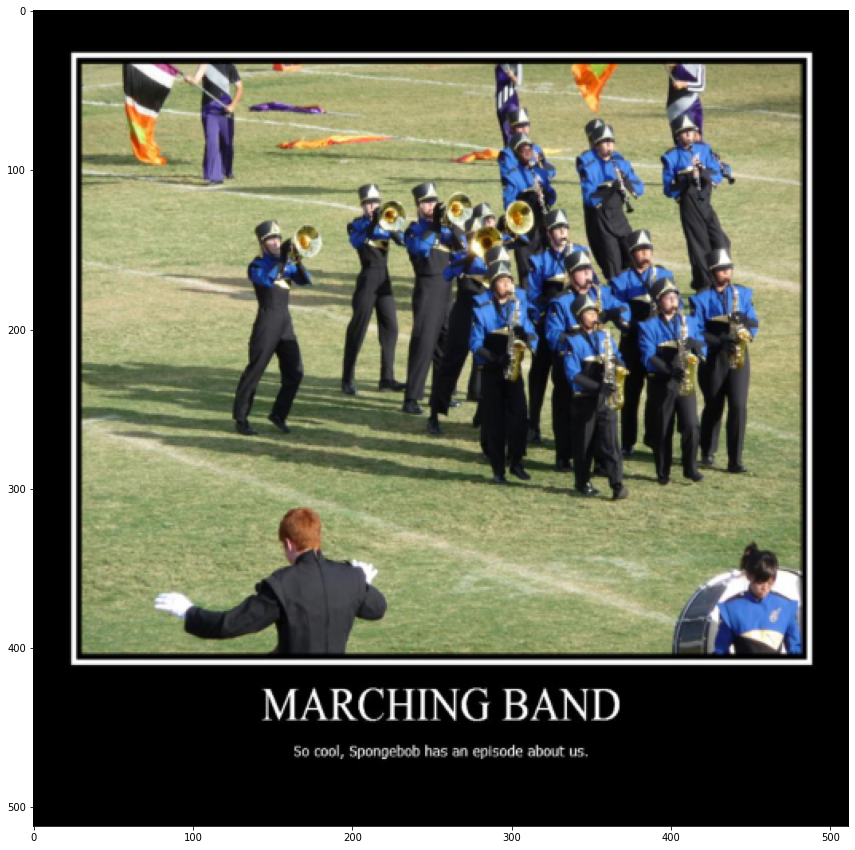

In [22]:
path = 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_test/images/0--Parade/0_Parade_marchingband_1_279.jpg'

img = Image.open(path)

img = np.array(img)
img = cv2.resize(img,(512,512))
plt.figure(figsize=(15,15))
plt.imshow(img)
#img = np.reshape(img,(1,512,512,3))
img = train_transforms(img)

#plt.imshow(np.reshape(img, (512,512,3)))

In [23]:
img = img.unsqueeze(0)
print(img.shape)

torch.Size([1, 3, 512, 512])


In [24]:
model(img.to(device))*99

tensor([[1.7319]], device='cuda:0', grad_fn=<MulBackward0>)

torch.Size([1, 3, 512, 512])


tensor([[4.9994]], device='cuda:0', grad_fn=<MulBackward0>)

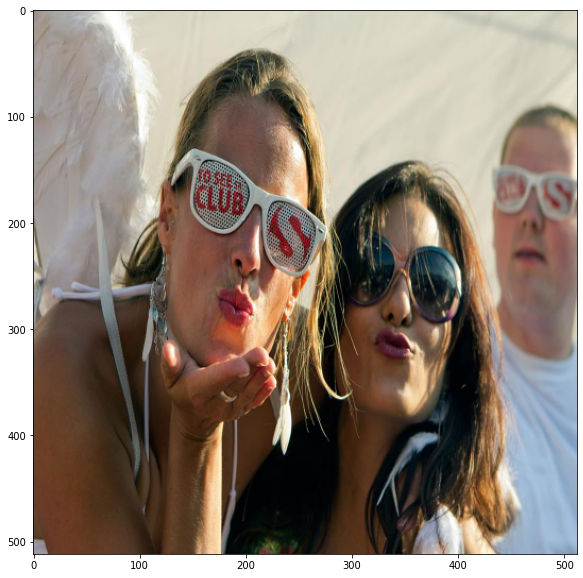

In [25]:
path = 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/detr-tensorflow/data/WIDERface/WIDER_test/images/0--Parade/0_Parade_Parade_0_708.jpg'

img = Image.open(path)

img = np.array(img)
img = cv2.resize(img,(512,512))
plt.figure(figsize=(10,10))
plt.imshow(img)
#img = np.reshape(img,(1,512,512,3))
img = train_transforms(img)

#plt.imshow(np.reshape(img, (512,512,3)))
img = img.unsqueeze(0)
print(img.shape)

model(img.to(device))*100

In [ ]:
#### Make testing on FDDB dataset

## Density maps

In [1]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import scipy
import json
from matplotlib import cm as CM
#from model import CSRNet
#import torch
%matplotlib inline

from tqdm import tqdm
import PIL
import cv2
import random
import math
import sys
import pandas as pd

import numpy as np

from __future__ import print_function

from itertools import chain
import zipfile

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [2]:
from vit_pytorch.vit import ViT
#from vit_pytorch.efficient import ViT
from vit_pytorch.recorder import Recorder

# Training settings
batch_size = 32
epochs = 100
lr = 3e-5
gamma = 0.7
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

device = 'cuda'


train_transforms = transforms.Compose(
    [
        #transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ]
)

In [3]:
#set the root to the Shanghai dataset you download
root = 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/Crowd_Counting_vit/ShanghaiTech_Crowd_Counting_Dataset/'

#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]
path_sets

['C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/Crowd_Counting_vit/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data\\images',
 'C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/Crowd_Counting_vit/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data\\images']

In [4]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(len(img_paths))

482


In [5]:
print(img_paths[0].replace('.jpg','.h5').replace('images','new_gt'))

C:/Users/Baptiste/Bureau/Baptiste/ARDUINO(a maxime)/Memoire/Crowd_Counting_vit/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data\new_gt\IMG_1.h5


(64, 64)


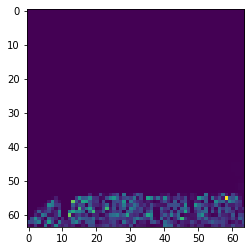

In [6]:
def get_output(path):
    #import target
    #resize target
    
    gt_file = h5py.File(path,'r')
    
    target = np.asarray(gt_file['density'])
    #print(target.shape)
    
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    
    #print("target shape :", target.shape)
    #print("output shape :", img.shape)
    
    #img = np.expand_dims(img,axis  = 2)
    
    #print(img.shape)
    
    return img

print(get_output(img_paths[0].replace('.jpg','.h5').replace('images','new_gt')).shape)
plt.imshow(get_output(img_paths[0].replace('.jpg','.h5').replace('images','new_gt')))

In [7]:
train_paths = [paths for paths in img_paths if 'train_data' in paths]
test_paths = [paths for paths in img_paths if 'test_data' in paths]

In [8]:
len(train_paths)

300

In [9]:
train, valid = train_test_split(train_paths,test_size=0.2,random_state=seed)

print(len(train))
print(len(valid))

240
60


In [10]:
class load_dataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)
        img = cv2.resize(img, (512,512))
        
        img=img/255.0
        #img = np.reshape(img, (3,512,512))
        img_transformed = self.transform(img)
        #print(img.shape, img_transformed.shape, img_path)

        label = get_output(img_paths[idx].replace('.jpg','.h5').replace('images','new_gt'))

        return img_transformed, label

In [11]:
train_data = load_dataset(train, transform=train_transforms)
valid_data = load_dataset(valid, transform=train_transforms)
test_data = load_dataset(test_paths, transform=train_transforms)

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

In [12]:
print(len(train_data), len(train_loader))

240 8


In [13]:
train_data[0][1]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02458491, 1.2864194 , 2.8556733 , ..., 0.32614672, 1.7096334 ,
        1.1520886 ],
       [1.3819853 , 1.2319444 , 1.8050652 , ..., 0.59267026, 0.28585774,
        1.3409212 ],
       [0.289138  , 0.02616988, 0.82963943, ..., 0.60009784, 0.61796296,
        0.82675123]], dtype=float32)

In [22]:
class ViT_density(nn.Module):
    def __init__(self):
        super(ViT_density, self).__init__()
        self.vit = ViT(
                    image_size = 512,
                    patch_size = 32,
                    num_classes = 1,
                    dim = 128,#1024
                    depth = 3,#6
                    heads = 8,#16
                    mlp_dim = 128,#1024
                    dropout = 0.1,
                    emb_dropout = 0.1
                )
        self.recorder = Recorder(self.vit)
        # deconvolution layers
        self.conv_block = nn.Sequential(
            nn.ConvTranspose2d(257, 32, kernel_size=9, stride=1),
            nn.ConvTranspose2d(32, 64, kernel_size=6, stride=2),
            #nn.ConvTranspose2d(257, 128, kernel_size=6, stride=1),
            #nn.ConvTranspose2d(128, 128, kernel_size=6, stride=1),
            #nn.ConvTranspose2d(128, 64, kernel_size=6, stride=1),
            nn.ConvTranspose2d(64, 64, kernel_size=5, stride=1),
            nn.ConvTranspose2d(64, 64, kernel_size=5, stride=1),
            nn.ConvTranspose2d(64, 64, kernel_size=5, stride=1),
            nn.ConvTranspose2d(64, 1, kernel_size=1, stride=1)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        #x = self.vit(x)
        x = x.float()
        preds, attns = self.recorder(x)
        #attn_heatmap = attns[:,-1,-1, :, 1:].reshape((batch_size,257,16, 16))#.detach().cpu().numpy()
        attn_heatmap = attns[:,-1,-1,:,1:].view((batch_size,257,16,16))
        #print(type(attn_heatmap))
        
        x = self.conv_block(attn_heatmap)
        #print(x.shape, type(x))
        
        return x

In [23]:
model = ViT_density()#.to(device)
#img = torch.randn(batch_size,3, 512, 512).to(device)
#x = model(img)
#print(x.shape)

In [24]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [25]:
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    return torch.sqrt(torch.sum(torch.square(y_pred - y_true)))

In [26]:
# loss function
#criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [27]:
el = []
ea = []
evl = []
eva = []

In [28]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        if len(data)==batch_size:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            #loss = criterion(output, label)
            loss = euclidean_distance_loss(output, label)
            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #output = output.cpu()
            mae = torch.abs(output-label).float().mean()
            epoch_accuracy += mae / len(train_loader)
            epoch_loss += loss / len(train_loader)
    #print(epoch_accuracy, epoch_loss, mae)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            if len(data)==batch_size:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                #val_loss = criterion(val_output, label)
                val_loss = euclidean_distance_loss(val_output, label)

                mae = torch.abs(val_output-label).float().mean()
                #acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += mae / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)
    
    el.append(epoch_loss)
    ea.append(epoch_accuracy)
    evl.append(epoch_val_loss)
    eva.append(epoch_val_accuracy)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 1 - loss : 1124.8778 - acc: 0.5130 - val_loss : 571.9358 - val_acc: 0.2428



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 2 - loss : 775.8887 - acc: 0.3106 - val_loss : 330.0391 - val_acc: 0.0980



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 3 - loss : 610.3450 - acc: 0.2110 - val_loss : 376.7929 - val_acc: 0.1402



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 4 - loss : 604.7356 - acc: 0.2178 - val_loss : 365.8780 - val_acc: 0.1032



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 5 - loss : 569.4473 - acc: 0.1603 - val_loss : 319.5833 - val_acc: 0.0874



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 6 - loss : 555.6171 - acc: 0.1519 - val_loss : 347.7507 - val_acc: 0.0949



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 7 - loss : 540.6655 - acc: 0.1651 - val_loss : 315.4888 - val_acc: 0.0950



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 8 - loss : 524.2737 - acc: 0.1572 - val_loss : 350.5672 - val_acc: 0.0888



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 9 - loss : 521.6326 - acc: 0.1413 - val_loss : 306.0030 - val_acc: 0.0802



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 10 - loss : 513.8370 - acc: 0.1445 - val_loss : 281.9862 - val_acc: 0.0810



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 11 - loss : 502.8817 - acc: 0.1404 - val_loss : 297.7972 - val_acc: 0.0786



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 12 - loss : 486.5177 - acc: 0.1324 - val_loss : 276.2178 - val_acc: 0.0749



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 13 - loss : 480.2558 - acc: 0.1305 - val_loss : 294.6150 - val_acc: 0.0765



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 14 - loss : 478.4385 - acc: 0.1295 - val_loss : 306.2579 - val_acc: 0.0752



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 15 - loss : 474.2026 - acc: 0.1299 - val_loss : 250.0743 - val_acc: 0.0682



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 16 - loss : 474.6180 - acc: 0.1233 - val_loss : 280.8588 - val_acc: 0.0718



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 17 - loss : 460.8699 - acc: 0.1229 - val_loss : 266.1355 - val_acc: 0.0660



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 18 - loss : 456.9845 - acc: 0.1209 - val_loss : 199.3154 - val_acc: 0.0618



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 19 - loss : 455.8809 - acc: 0.1177 - val_loss : 318.0152 - val_acc: 0.0732



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 20 - loss : 442.8876 - acc: 0.1155 - val_loss : 298.1077 - val_acc: 0.0682



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 21 - loss : 445.0504 - acc: 0.1162 - val_loss : 246.9931 - val_acc: 0.0613



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 22 - loss : 449.2102 - acc: 0.1172 - val_loss : 229.0476 - val_acc: 0.0574



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 23 - loss : 438.7866 - acc: 0.1079 - val_loss : 248.8701 - val_acc: 0.0644



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 24 - loss : 435.0477 - acc: 0.1110 - val_loss : 241.4818 - val_acc: 0.0578



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 25 - loss : 436.7155 - acc: 0.1057 - val_loss : 228.3272 - val_acc: 0.0575



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 26 - loss : 418.4005 - acc: 0.1075 - val_loss : 325.7474 - val_acc: 0.0665



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 27 - loss : 421.0912 - acc: 0.1071 - val_loss : 250.7386 - val_acc: 0.0574



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 28 - loss : 432.1154 - acc: 0.1032 - val_loss : 235.3415 - val_acc: 0.0563



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 29 - loss : 427.0009 - acc: 0.1042 - val_loss : 241.8003 - val_acc: 0.0570



  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 30 - loss : 425.2256 - acc: 0.1006 - val_loss : 280.4229 - val_acc: 0.0635



  0%|          | 0/8 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 194.00 MiB (GPU 0; 6.00 GiB total capacity; 4.89 GiB already allocated; 0 bytes free; 5.22 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [22]:
torch.save(model.state_dict(), 'torch_models/vit_density.pth')

In [33]:
model.load_state_dict(torch.load('torch_models/vit_density.pth'))

<All keys matched successfully>

In [25]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+-----------------------------------------------+------------+
|                    Modules                    | Parameters |
+-----------------------------------------------+------------+
|               vit.pos_embedding               |   32896    |
|                 vit.cls_token                 |    128     |
|        vit.to_patch_embedding.1.weight        |   393216   |
|         vit.to_patch_embedding.1.bias         |    128     |
|     vit.transformer.layers.0.0.norm.weight    |    128     |
|      vit.transformer.layers.0.0.norm.bias     |    128     |
|  vit.transformer.layers.0.0.fn.to_qkv.weight  |   196608   |
| vit.transformer.layers.0.0.fn.to_out.0.weight |   65536    |
|  vit.transformer.layers.0.0.fn.to_out.0.bias  |    128     |
|     vit.transformer.layers.0.1.norm.weight    |    128     |
|      vit.transformer.layers.0.1.norm.bias     |    128     |
|   vit.transformer.layers.0.1.fn.net.0.weight  |   16384    |
|    vit.transformer.layers.0.1.fn.net.0.bias   |    12

2361602

In [23]:
4978690-2664576

2314114

In [61]:
print(model)

ViT_density(
  (vit): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): Linear(in_features=3072, out_features=128, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (attend): Softmax(dim=-1)
              (dropout): Dropout(p=0.1, inplace=False)
              (to_qkv): Linear(in_features=128, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=128, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
          )
          (1): PreNorm(
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (fn): FeedForward(
              (net): Seq

In [11]:
v = ViT(
    image_size = 512,
    patch_size = 32,
    num_classes = 1,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [12]:
# forward pass now returns predictions and the attention maps
model = Recorder(v).to(device)

img = torch.randn(1, 3, 512, 512).to(device)
preds, attns = model(img)

In [13]:
print(attns.shape)

torch.Size([1, 6, 16, 257, 257])


In [21]:
attn_heatmap = attns[0,-1,-1, :, 1:].reshape((1,16, 16,257)).detach().cpu().numpy()
print(attn_heatmap.shape)

(1, 16, 16, 257)


In [16]:
14*14

196

In [33]:
path = "ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data/new_gt/IMG_316.h5"
path = path.replace('.h5','.jpg').replace('new_gt','images')
output = get_output(path.replace('.jpg','.h5').replace('images','new_gt') )

image shape : (1, 512, 512, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-86.200424


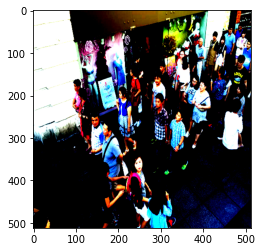

In [34]:
count,image,ans = predict(path,model)
print(count)
plt.imshow(image[0])